In [1]:
import math
import os
import json

import torch
from torch import nn, optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import List, Dict

In [2]:
from src.env import PuzzleEnv
from src.agent import Agent
from src.dqn import DQN
from src.visualization.plotting import (
    imshow_cube,
    plot_history,
    plot_success_length,
    plot_success_rate,
)
from src.train.result_utils import ResultManager, save_history

In [3]:
device = "cpu"

For DQN we'll use a simple FFN similar to dist_predictor


In [4]:
env_config = {
    "exp_name": "C3_test",
    "puzzle_name": "cube_3x3x3",
    "num_envs": 256,
    "max_steps": 20,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 5],
        "extra_generation": 4,
    },
    "reward_config": {
        "success": 10,
        "time": -0.1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)

agent_config = {
    "inp": env.state_size,
    "oup": env.num_actions,
    "batch_size": env.num_envs,
    "gamma": 0.99,
    "epsilon_schedule": "exp",
    "epsilon_start": 0.9,
    "epsilon_end": 0.05,
    "epsilon_decay": 50000,
    "tau": 0.005,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "optimizer": "adam",
    "network_units": [128, 256, 128],
}

Loaded cube_3x3x3: 18 actions, 54 states


In [5]:
env = PuzzleEnv(env_config)
agent = Agent(agent_config)


# initiate history template
history = {
    "reward": [],
    "avg_success": [],
    "loss": [],
    "success_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
    "success_length_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
}


def train(env, agent, episodes, history):
    s = env.reset()
    s = torch.tensor(s, device=device)
    for _ in tqdm(range(episodes)):
        for _ in range(env_config["max_steps"]):
            a = agent.select_action(s)
            s_n, r, terminated, mask = env.step(a)
            s_n = torch.tensor(s_n, device=device)

            loss = agent.optimize(s, a, r, s_n, terminated, mask)
            s = s_n
            agent.update_target_net()

        history["loss"].append(loss)
        history["reward"].append(
            env.get_cumulative_reward().sum().item() / env.num_envs
        )
        (
            success_rate_per_n,
            success_length_per_n,
            average_success,
        ) = env.get_completion_rate()
        history["avg_success"].append(average_success)
        for n in success_rate_per_n.keys():
            history["success_per_n"][f"{n}"].append(success_rate_per_n[n])
            history["success_length_per_n"][f"{n}"].append(success_length_per_n[n])

Loaded cube_3x3x3: 18 actions, 54 states


In [6]:
train(env, agent, episodes=100, history=history)
print(sum(history["avg_success"][-100:]) / len(history["avg_success"][-100:]))
# print(history["avg_success"][-1])

100%|██████████| 100/100 [00:08<00:00, 12.23it/s]

0.0432714844140625


In [7]:
def load_experiment(exp_folder):
    for f in [
        "env_config.json",
        "agent_config.json",
        "history.json",
        "target_net.pt",
        "policy_net.pt",
    ]:
        if f not in os.listdir(exp_folder):
            print(f"Warning: did not find {f} in {exp_folder}")
            return
    print("found all files, loading configs...")
    with open(os.path.join(exp_folder, "env_config.json"), "r+") as f:
        env: PuzzleEnv = PuzzleEnv(json.load(f))
    with open(os.path.join(exp_folder, "agent_config.json"), "r+") as f:
        agent: Agent = Agent(json.load(f))

    print("loading network checkpoints...")
    agent.target_network = torch.load(os.path.join(exp_folder, "target_net.pt"))
    agent.policy_network = torch.load(os.path.join(exp_folder, "policy_net.pt"))
    agent.optimizer = torch.load(os.path.join(exp_folder, "optimizer.pt"))

    with open(os.path.join(exp_folder, "history.json")) as f:
        history = json.load(f)
    print("successfully loaded checkpoint")
    return env, agent, history

In [8]:
result_manager = ResultManager(agent, env)

saving configs...
saved env and agent configs
saving networks...
saved policy network and target networks


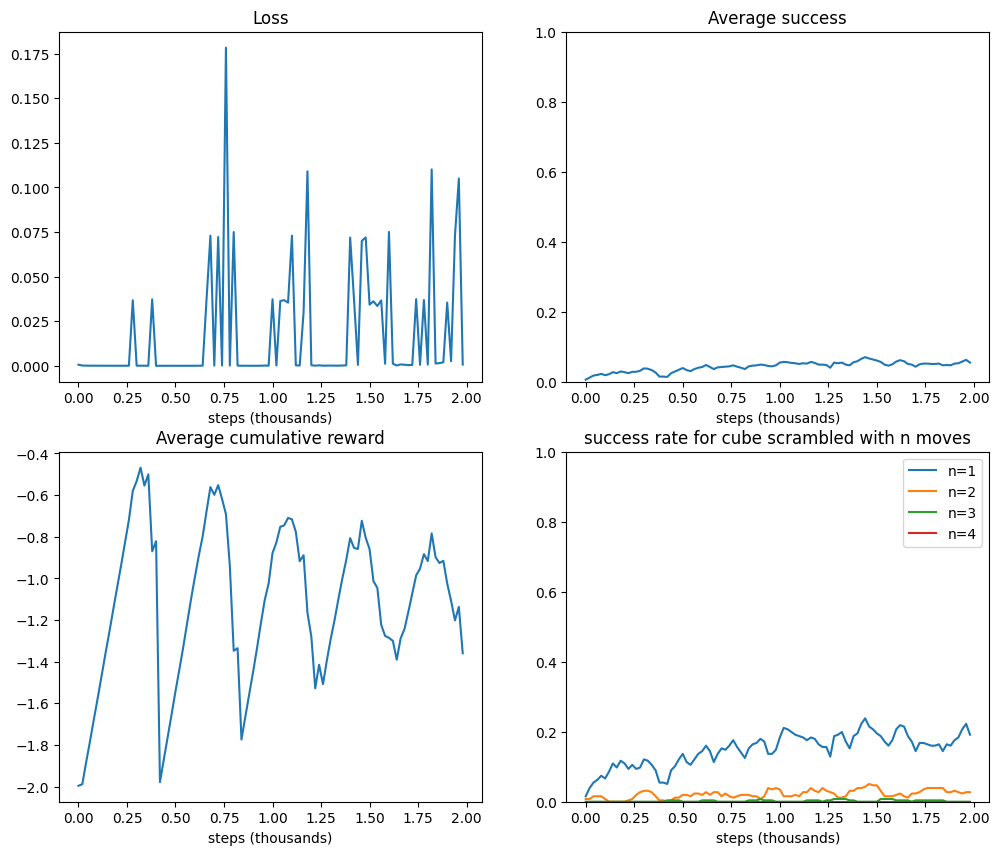

In [9]:
result_manager.save()

save_history(history, result_manager.directory)
plot_history(history, episode_length=20, save_to_folder=result_manager.directory)

In [10]:
eval_stats = result_manager.evaluate(steps=2500)

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:06<00:00, 407.29it/s]


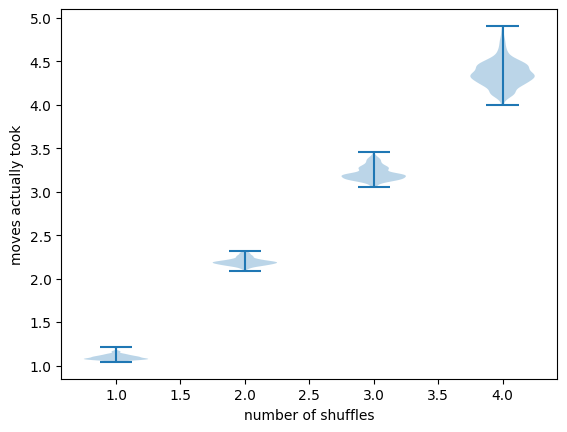

In [11]:
plot_success_length(
    eval_stats["success_length_per_n"], save_to_folder=result_manager.directory
)

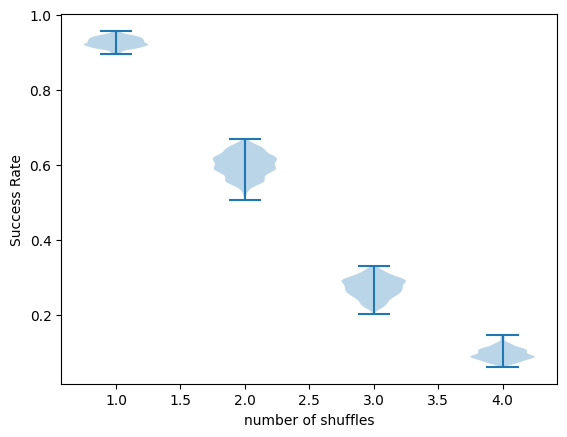

In [12]:
plot_success_rate(eval_stats["success_per_n"], save_to_folder=result_manager.directory)

In [13]:
env, agent, history = load_experiment("results/C3_test")

found all files, loading configs...
Loaded cube_3x3x3: 18 actions, 54 states
loading network checkpoints...
successfully loaded checkpoint


In [14]:
train(env, agent, 50, history)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


### Dive into inference more

In [ ]:
from src.mechanism.utils import get_inverse_move

sample_state = env.states[0]
sample_shuffle = env.gt_moves[0]

print(sample_shuffle)
print(env.action_names)

inv_move = get_inverse_move(sample_shuffle[0])
idx = list(env.action_names).index(inv_move)
print(f"inverse move {inv_move} on index {idx}")
env.step([idx])

In [ ]:
env.step([0])

sample_state = env.states[0]

print(env.states[0])
print(env.gt_moves[0])